N 1000


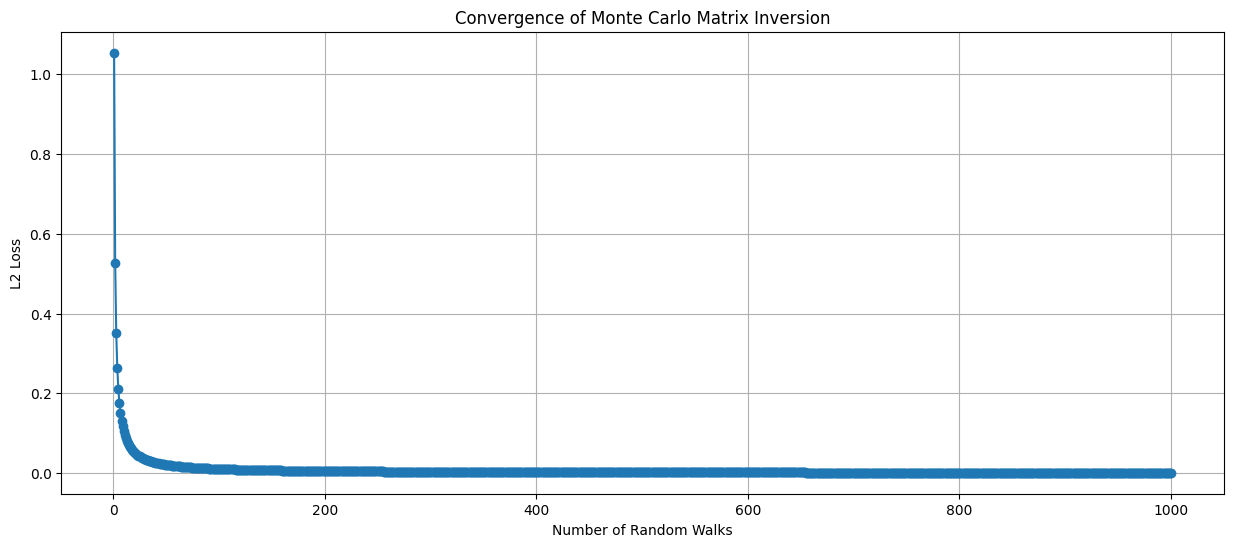

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, norm

def monte_carlo_matrix_inversion(B, epsilon=1e-5, delta=1e-5, max_steps=100):
    n = B.shape[0]

    # Step 2: Split B = M - K, where M is diagonal, K is off-diagonal
    M = np.diag(np.diag(B))
    K = B - M

    # Step 2: Compute C = M^-1 * K
    M_inv = inv(M)
    C = np.dot(M_inv, K)

    # Step 2.3: Compute ||C|| and the number of Markov chains N
    C_norm = norm(C, ord=np.inf)
    if C_norm >= 1:
        raise ValueError("Norm condition not satisfied, ||C|| must be < 1")

    N =  int(min(1000, ((0.5 / epsilon) / (1 - C_norm)) ** 2))
    # int(((0.6745 / epsilon) * (1/(1 - norm_C))) ** 2)
    print("N", N)

    # Initialize Q as zero matrix
    Q = np.zeros_like(B, dtype=float)
    l2_losses = []  # Track L2 loss for convergence

    # Step 3: Loop through i=1 to n
    Q_prev = np.zeros_like(Q, dtype=float)
    for chain_idx in range(1, N + 1):
        for i in range(n):
            sum_i = np.zeros(n)

            # Run one Markov chain for the current row
            W = 1.0
            current_state = i
            tk = 0  # Stopping rule

            # Generate random walk for each chain
            for step in range(max_steps):
                # Compute transition probabilities
                row_abs_sum = np.sum(np.abs(C[current_state]))
                if row_abs_sum == 0:
                    break  # No transitions possible, end the chain

                probabilities = np.abs(C[current_state]) / row_abs_sum
                next_state = np.random.choice(n, p=probabilities)

                # If C[current_state, next_state] != 0, proceed
                if C[current_state, next_state] != 0:
                    # Update weight W and accumulate sum
                    W *= C[current_state, next_state] / probabilities[next_state]
                    sum_i[next_state] += W

                    # Update state and check stopping conditions
                    current_state = next_state
                    if abs(W) < delta:
                        tk += 1
                    if tk >= n:
                        break  # End of chain if weight is too small

            # Update the sum for the ith row
            Q[i] += sum_i / chain_idx

        # Calculate and store L2 loss for convergence after all rows are updated
        l2_loss = np.linalg.norm(Q - Q_prev)
        l2_losses.append(l2_loss)
        Q_prev = Q.copy()

    # Step 4: Compute H = (I - C)^-1 and Q_n = H * M^-1
    H = inv(np.eye(n) - C)
    Q_n = np.dot(H, M_inv)

    # Step 5: Iterative update for Q_n
    for i in range(n - 1, -1, -1):
        K_i = B - np.diag(np.diag(B))
        Q_n = Q_n + np.dot(np.dot(Q_n, K_i), Q_n) / (1 - np.trace(np.dot(K_i, Q_n)))

    # Step 6: Set B_n^-1 = Q_n
    B_inv = Q_n

    return B_inv, l2_losses

# Example: Very Simple Test Matrix and Convergence Plot
def simple_example():
    # Very simple test matrix B
    B = np.array([
        [2, -1],
        [-1, 2]
    ])

    # Run the Monte Carlo matrix inversion and track convergence
    _, l2_losses = monte_carlo_matrix_inversion(B, max_steps=100)

    # Plot L2 loss for convergence across the number of random walks
    plt.plot(range(1, len(l2_losses) + 1), l2_losses, marker='o')
    plt.gcf().set_size_inches(15, 6)
    plt.xlabel('Number of Random Walks')
    plt.ylabel('L2 Loss')
    plt.title('Convergence of Monte Carlo Matrix Inversion')
    plt.grid(True)
    plt.show()

# Run the simple example
simple_example()
